In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input

In [6]:
Train_data = "Dataset/train/"
Test_data = 'Dataset/valid/'
train_data_df = pd.DataFrame(columns=['Image_path','Label'])
test_data_df = pd.DataFrame(columns=['Image_path'])

In [7]:
def load_dataframe(DF,path):
    labels_files = os.listdir(path)
    image_paths = []
    labels = []
    for file in labels_files:
        path_file = path + file +'\\'
        list_files = os.listdir(path_file)
        for image_path in list_files:
            image_paths.append(path_file + image_path)
            labels.append(file)
    DF['Image_path'] = image_paths
    DF['Label'] = labels
    return(DF)

In [8]:
train_data_df = load_dataframe(train_data_df,Train_data)
test_data_df = load_dataframe(test_data_df,Test_data)

train_data_df = shuffle(train_data_df)
test_data_df = shuffle(test_data_df)

encoder = LabelEncoder()
train_data_df['Label'] = encoder.fit_transform(train_data_df['Label'])
test_data_df['Label'] = encoder.fit_transform(test_data_df['Label'])

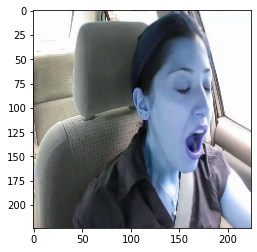

(224, 224, 3)

In [9]:
import cv2
def load_image(path):
    img = cv2.imread(path,1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    img = cv2.resize(img,(224,224))
    return img

img = load_image(train_data_df['Image_path'][0])
fig,ax = plt.subplots(1)
ax.imshow(img)
plt.show()
img.shape

In [10]:
x_train = []
for image_path in train_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_train.append(img)
x_train = np.array(x_train)

In [11]:
x_test = []
for image_path in test_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_test.append(img)
x_test = np.array(x_test)

In [12]:
y_train = train_data_df['Label'].to_list()
y_test = test_data_df['Label'].to_list()

In [13]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=3)
y_train = y_train.reshape(y_train.shape[0],1,1,y_train.shape[1])
y_test = to_categorical(y_test,num_classes=3)
y_test = y_test.reshape(y_test.shape[0],1,1,y_test.shape[1])

In [14]:
from tensorflow.keras.applications.mobilenet import MobileNet 
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Conv2DTranspose,Dropout,Dense,MaxPool2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable    

    x =  model.output
    x = Conv2D(512, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Dense(512,activation = 'relu')(x)
    x = Dense(3,activation = 'softmax')(x)
    return(Model(inputs = model.input,outputs = x))

In [15]:
model = create_model(False)
import tensorflow
Optimizer = tensorflow.keras.optimizers.Adam(learning_rate = 1e-6,beta_1 = 0.9,decay = 1e-5)

model.compile(optimizer= Optimizer,loss= 'categorical_crossentropy',metrics= 'accuracy')

In [16]:
# EarlyStopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta = 0.01)
# # Model Checkpoint
# ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint("pneu_2-{val_loss:.3f}.h5",monitor='val_loss',save_best_only= True,save_weights_only=True)
# model_history = model.fit(x_train,y_train,epochs = 2,batch_size = 1,validation_data = (x_test,y_test),callbacks=[ModelCheckpoint,EarlyStopping])

In [17]:
model_history = model.fit(x_train,y_train, validation_data = (x_test,y_test),epochs=10,batch_size = 1)

Epoch 1/10
2467/2467 [==============================] - 176s 71ms/step - loss: 0.4621 - accuracy: 0.7892 - val_loss: 0.3041 - val_accuracy: 0.8661
Epoch 2/10
2467/2467 [==============================] - 157s 64ms/step - loss: 0.1924 - accuracy: 0.9380 - val_loss: 0.2073 - val_accuracy: 0.9169
Epoch 3/10
2467/2467 [==============================] - 164s 66ms/step - loss: 0.1083 - accuracy: 0.9830 - val_loss: 0.1563 - val_accuracy: 0.9400
Epoch 4/10
2467/2467 [==============================] - 169s 69ms/step - loss: 0.0642 - accuracy: 0.9947 - val_loss: 0.1214 - val_accuracy: 0.9607
Epoch 5/10
2467/2467 [==============================] - 173s 70ms/step - loss: 0.0373 - accuracy: 0.9988 - val_loss: 0.0999 - val_accuracy: 0.9561
Epoch 6/10
2467/2467 [==============================] - 179s 72ms/step - loss: 0.0218 - accuracy: 0.9996 - val_loss: 0.0815 - val_accuracy: 0.9769
Epoch 7/10
2467/2467 [==============================] - 188s 76ms/step - loss: 0.0132 - accuracy: 0.9996 - val_loss: 0

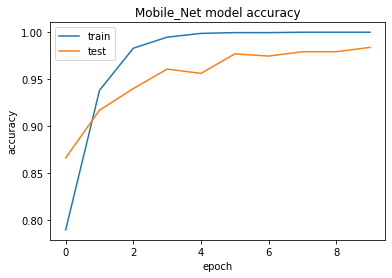

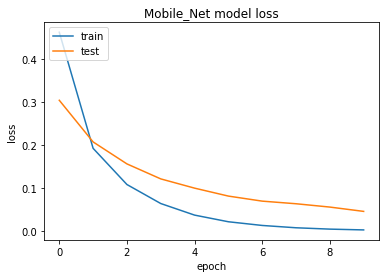

In [18]:
def plotModelAccuracy(history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

plotModelAccuracy(model_history, 'Mobile_Net')

In [ ]:
# import tensorflow as tf
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils import shuffle
# import cv2
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications.mobilenet import preprocess_input
# from myhdl import *

# def predict(image):
#     _model = create_model(True)
#     _model.load_weights('pneu_2-0.628.h5')
#     image = cv2.resize(image, (224,224))
#     pred = _model.predict(np.array(image).reshape(1,224,224,3))
#     lab = encoder.classes_[np.argmax(pred)]
#     return(lab)

# image = cv2.imread('D:\\Omkar Project\\chest_xray\\train\\normal\\IM-0191-0001.jpeg', 1)
# predict(image)

# converter = tf.lite.TFLiteConverter.from_keras_model(_model) # path to the SavedModel directory
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = converter.convert()
# with open('mobnet_model1.tflite', 'wb') as f:
#     f.write(tflite_model)